# Aim

Implement turbulence fitting in the frequency domain.

In [188]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import welch
from scipy import stats, optimize
import sys
from tqdm import tqdm
import warnings

sys.path.append("..")
from src import SystemIdentifier
from src import genpsd
from src.controllers.identifier import log_likelihood

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
ol = np.load("../data/tt_center_noise/tt_center_noise_nsteps_10000_delay_0.01_dt_21_07_2021_12.npy")

In [96]:
# first, try to replicate Meimon 2010's Figure 7
nsteps = 100000
ident = SystemIdentifier(ol[:2000], fs=1)
# kvals = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 5, 10]
kvals = [0.001, 0.05, 0.2, 0.4, 0.8, 2, 5]
freqs = np.arange(0.01, 10.0, 0.01)

def make_A(k, f):
    a1 = 2 * np.exp(-2*k*np.pi*f / ident.fs) * np.cos(2*np.pi*f/(ident.fs * np.sqrt((1 - k**2)+0j)))
    a2 = -np.exp(-4*k * np.pi * f / ident.fs)
    return a1, a2

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


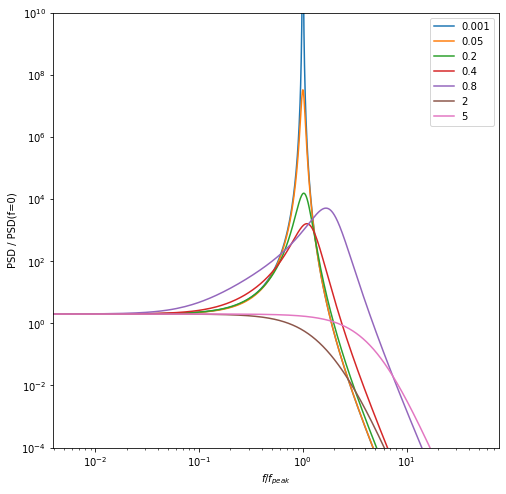

In [108]:
plt.figure(figsize=(8,8))
x0 = [1, 0]
fpeak = 0.01
with np.errstate(invalid="ignore"):
    for k in tqdm(kvals):
        a1, a2 = make_A(k, fpeak)
        states = np.zeros((nsteps,))
        states[:2] = x0
        for i in range(2, nsteps):
            states[i] = a1 * states[i-1] + a2 * states[i-2]# + 1e-4 * np.random.randn()

        f, p = genpsd(states, dt=1, remove_dc=False)
        plt.loglog(f / fpeak, p / p[0], label=k)
    plt.xlabel(r"$f / f_{peak}$")
    plt.ylabel("PSD / PSD(f=0)")
    plt.ylim(1e-4, 1e10)
    plt.legend()

So I can do that, cool. I'm convinced that a turbulence pattern can be fit well by the same damped-exp modes we've been using for vibrations. Now to do it.

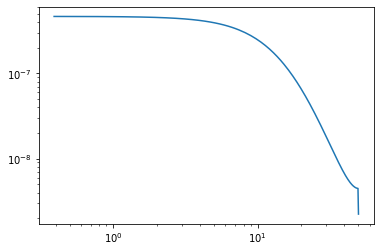

In [118]:
plt.loglog(*genpsd(ident.damped_harmonic([1000, 2, 0.1, 0])))

In [120]:
ol_turb_sim = np.load("../data/sims/ol_atm_1_vib_0.npy")

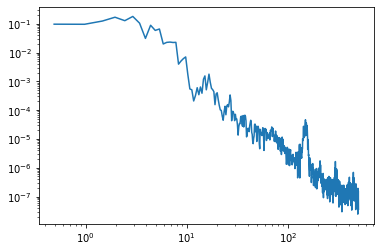

In [146]:
f, p = genpsd(ol_turb_sim[:,0], dt=0.001)
ident.fs = 1000
ident.f1 = 1000 / 60
ident.f2 = 1000 / 3
plt.loglog(f, p)

In [153]:
mask = np.logical_and(ident.f1 < f, f < ident.f2)

In [162]:
res = ident.interpolate_psd(f, p)
m, b = res.slope, res.intercept

In [181]:
pfit = np.exp(b) * f ** m
np.where(np.abs(p - pfit)[mask] > 5e-3*res.stderr)

(array([0, 1]),)

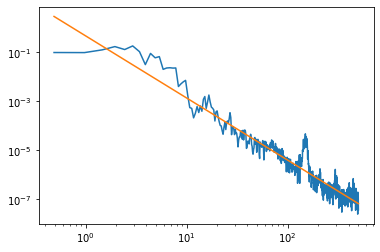

In [168]:
plt.loglog(f, p)
plt.loglog(f, pfit)

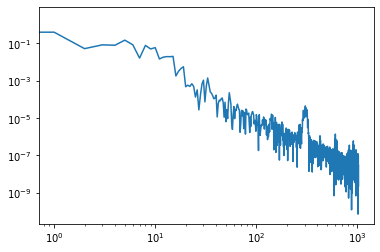

In [184]:
plt.loglog(np.abs(p - pfit))

In [243]:
ident = SystemIdentifier(ol_turb_sim, fs=1000)
ll = log_likelihood(ident.make_psd, p)
optres = optimize.minimize(ll, (1e6, 0.01, 0.5, 0, 0.01), method="Nelder-Mead")
optval = optres.x
print(optres)

 final_simplex: (array([[-19.53759588,  -0.30381552,  -0.99733988,   0.20426476,
          0.65218834],
       [-18.22513698,  -0.30366789,  -0.9961172 ,   0.20416616,
          0.65188363],
       [-18.60888682,  -0.30228532,  -0.98459158,   0.20324222,
          0.64902906],
       [-18.46474344,  -0.30037528,  -0.96866969,   0.20196579,
          0.64508544],
       [-18.58151781,  -0.29963065,  -0.9624581 ,   0.20146814,
          0.64354795],
       [-18.41931066,  -0.29820329,  -0.95055797,   0.20051426,
          0.64060089]]), array([1.00457620e+08, 1.00551555e+08, 1.01437976e+08, 1.02681990e+08,
       1.03173198e+08, 1.04124651e+08]))
           fun: 100457619.97116238
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 1001
           nit: 591
        status: 1
       success: False
             x: array([-19.53759588,  -0.30381552,  -0.99733988,   0.20426476,
         0.65218834])


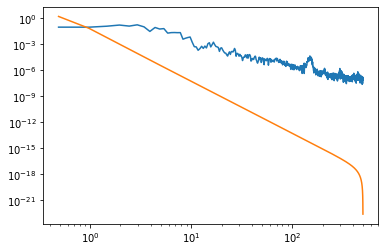

In [244]:
plt.loglog(f, p)
plt.loglog(*ident.make_psd(optval[:4]))